In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

import math
import os
import time

# unwarp the corners of the chessboard image
def cornersUnwarp(img, nx, ny, mtx, dist, corners):
    # Pass in your image into this function
    # Write code to do the following steps
    img_size = (img.shape[1], img.shape[0])
    # extra space for including more of the image
    xe = (corners[1][0][0] - corners[0][0][0])/2
    ye = (corners[nx][0][1] - corners[0][0][1])/2
    # source points
    src = np.float32((corners[0][0] - [xe, ye],
        corners[nx-1][0] + [xe, -ye],
        corners[(nx*ny)-1][0] + [xe, ye],
        corners[nx*(ny-1)][0] - [xe, -ye]))
    tl, tr, br, bl = src
    # destination points
    dst = np.float32([[0, 0],
        [img_size[0] - 1, 0],
        [img_size[0] - 1, img_size[1] - 1],
        [0, img_size[1] - 1]])
    # get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

# calibrate the camera and return the camera marix to be used later
def camCalibrate(img_name_list):
    for name in img_name_list:
        img = cv2.imread(name)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
        # If found, store imagepoint and object point data and draw corners
        if ret == True:
            objPoints.append(np.copy(objp))
            imgPoints.append(corners)
            #images.append(img)
    # get calibration parameters
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, gray.shape[::-1],
                                                           None, None, flags=cv2.CALIB_USE_INTRINSIC_GUESS)
    return mtx, dist
    
# get calibrated image
def getCaliberatedImage(image, mtx, dist):
    undist = np.zeros_like(image)
    undist[:,:,0] = cv2.undistort(image[:,:,0], mtx, dist, None, mtx)
    undist[:,:,1] = cv2.undistort(image[:,:,1], mtx, dist, None, mtx)
    undist[:,:,2] = cv2.undistort(image[:,:,2], mtx, dist, None, mtx)
    return undist

### Calibrate the Camera

In [2]:
# prepare object points
# number of inside corners in x and y
nx, ny = 23, 18
src_dir = 'mobile'
set_dir = 'set1'
# Store Object points and image points from all the images
objPoints = []  # 3D points in real world space
imgPoints = []  # 3D points in image place

# Prepare object points like (0,0,0), (1,0,0), (2,0,0)...(8,5,0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # a list of x, y coordinates

# Make a list of calibration images
image_names = glob.glob('./images/'+src_dir+'/calib/img*.jpg')
rows = len(image_names)

cam_mtx = None
cam_dist = None

# read all the images and prepare camera matrix
cam_mtx, cam_dist = camCalibrate(image_names)

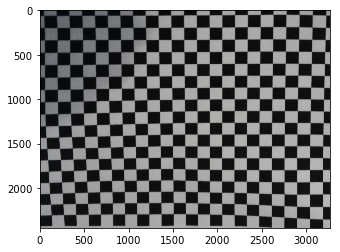

In [3]:
# test camera matrix on a chessboard image
img = cv2.imread(image_names[8])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # Convert to grayscale
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)    # Find the chessboard corners
undist = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
warped_image = cornersUnwarp(undist, nx, ny, cam_mtx, cam_dist, corners)
plt.imshow(warped_image)
plt.show()

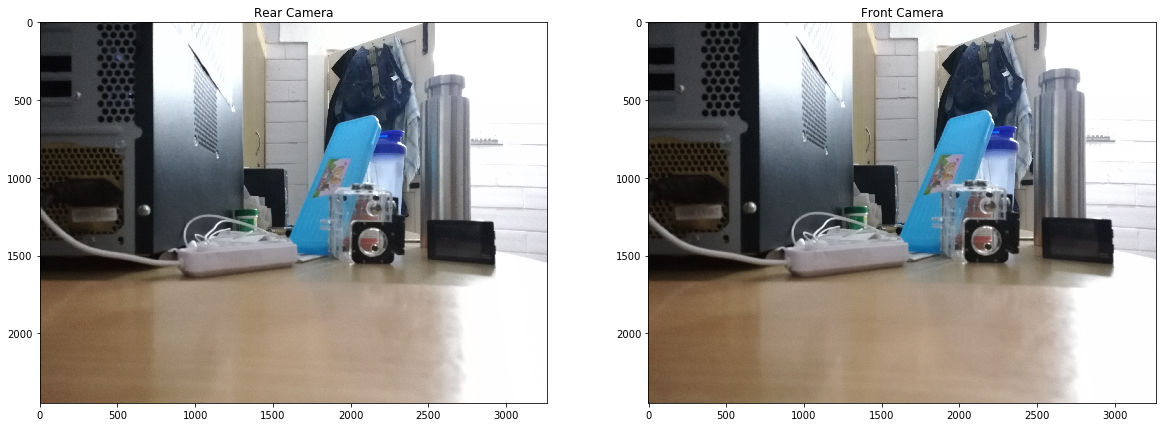

In [4]:
img_back = mpimg.imread('images/'+src_dir+'/'+set_dir+'/img_back.jpg')
img_front = mpimg.imread('images/'+src_dir+'/'+set_dir+'/img_front.jpg')

img_back = getCaliberatedImage(img_back, cam_mtx, cam_dist)
img_front = getCaliberatedImage(img_front, cam_mtx, cam_dist)

fig1 = plt.figure(figsize=(20, 20))
fig1.add_subplot(1, 2, 1)
plt.title("Rear Camera")
plt.imshow(img_back)

fig1.add_subplot(1, 2, 2)
plt.title("Front Camera")
plt.imshow(img_front)
plt.show()

In [5]:
# print image information
print("Rear camera image dimensions:",img_back.shape)
print("Front camera image dimensions:", img_front.shape)

Rear camera image dimensions: (2448, 3264, 3)
Front camera image dimensions: (2448, 3264, 3)


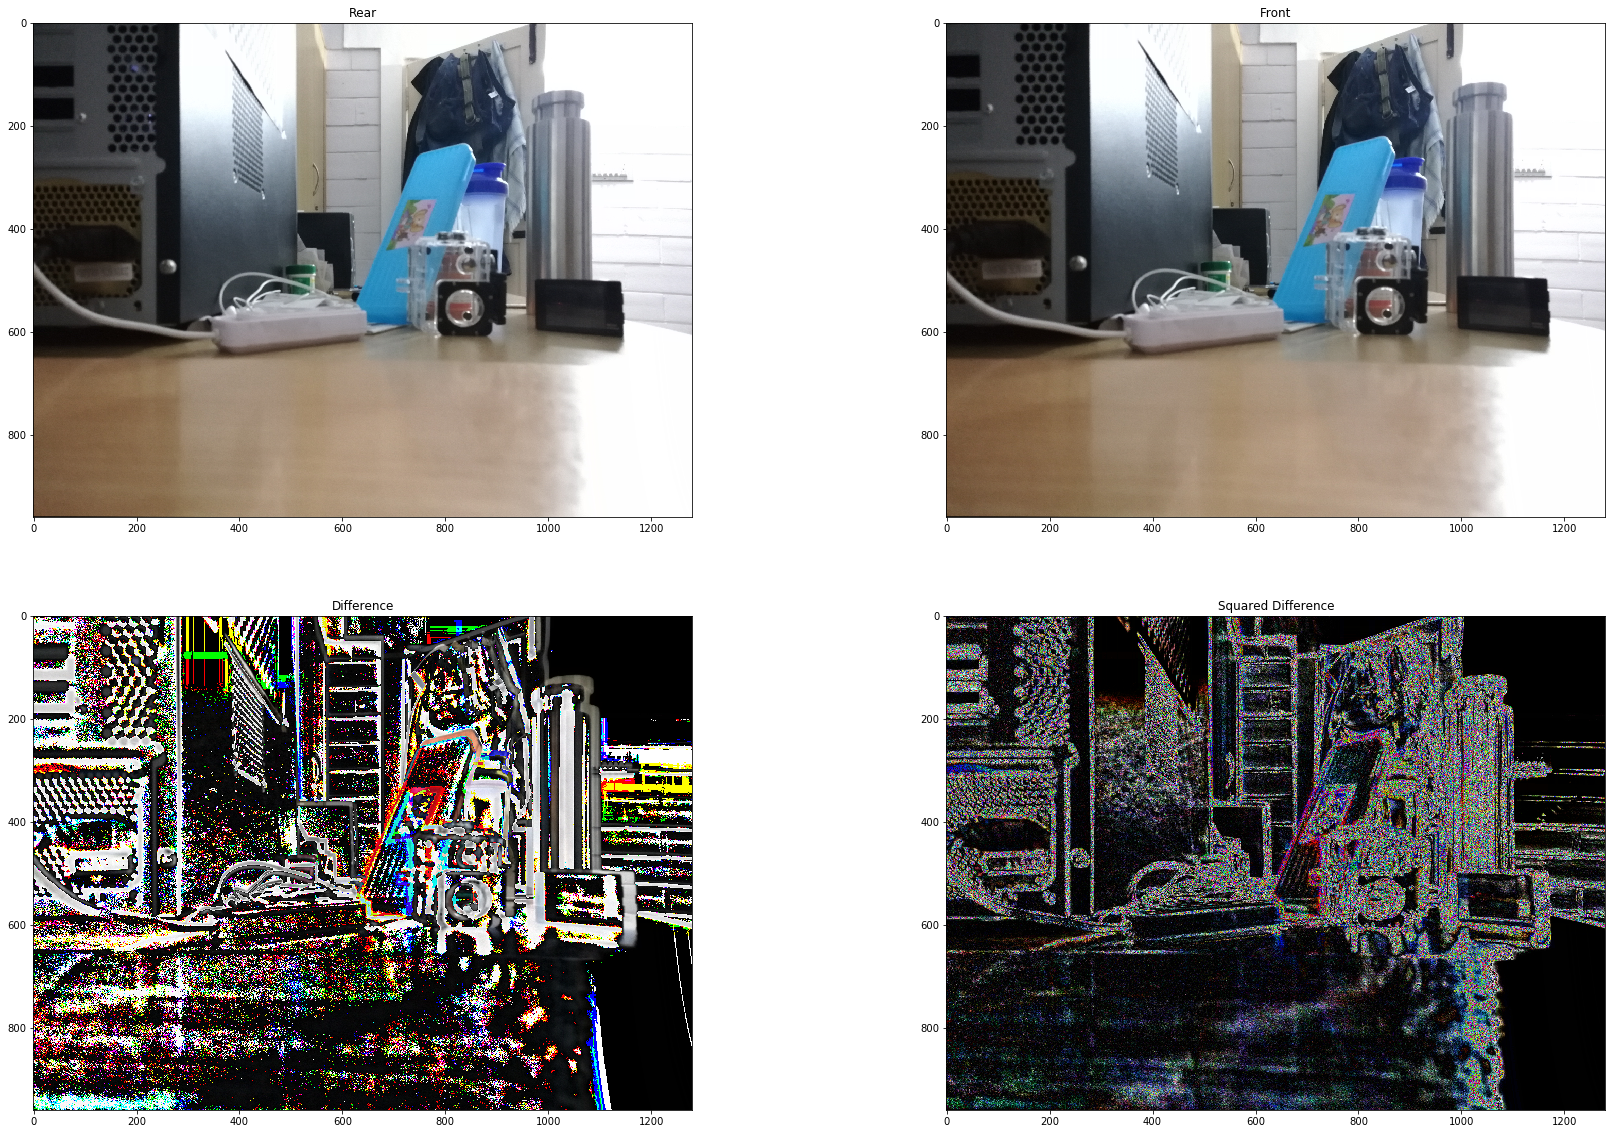

In [6]:
# Resize the images and check out the difference and squared differences
img_back = cv2.resize(img_back, (1280, 960))
img_front = cv2.resize(img_front, (1280, 960))
img_diff = (img_back - img_front)
img_sqdf =img_diff**2


fig1 = plt.figure(figsize=(30, 20))
fig1.add_subplot(2, 2, 1)
plt.title("Rear")
plt.imshow(img_back)

fig1.add_subplot(2, 2, 2)
plt.title("Front")
plt.imshow(img_front)

fig1.add_subplot(2, 2, 3)
plt.title("Difference")
plt.imshow(img_diff)

fig1.add_subplot(2, 2, 4)
plt.title("Squared Difference")
plt.imshow(img_sqdf)


In [32]:
# now we have two 720p images to compare
img_height, img_width = img_back.shape[:2]
print("width:", img_width, "height:", img_height)

# size of square filters to be used for matching
filter_size = 16
max_deviation = 24
stride = 8

# assuming cameras to be placed just in front of other and one in front to be invisible ;)
#distance between the camera_far and camera_near in meters
camera_d = 0.01

width: 1280 height: 960


98.828%
435.68 seconds to extract squared differences.


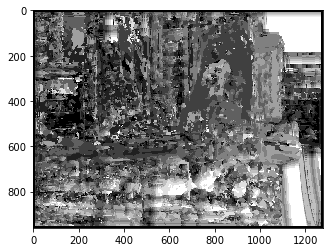

In [33]:
match_mask = np.zeros_like(img_front[:,:,0])
cnt = 0
t0=time.time()
# for each patch of filter_size in rear image
for fw in range(img_width - filter_size + 1):
    for fh in range(img_height - filter_size + 1):
        front_patch = img_front[fh:fh+filter_size, fw:fw+filter_size, :]
        # minimum sum of squared differences
        min_sosd = 9999999999
        # starting point
        bw = fw - max_deviation
        bh = fh - max_deviation
        if fw - max_deviation < 0:
            bw = 0
        if fh - max_deviation < 0:
            bh = 0
        
        ew = fw + max_deviation + 1
        eh = fh + max_deviation + 1
        if fw + max_deviation >= img_width - filter_size + 1:
            ew = img_width - filter_size
        if fh + max_deviation >= img_height - filter_size + 1:
            eh = img_height - filter_size
        
        tmp_mask = np.zeros_like(match_mask[:filter_size, :filter_size])
        msk_wh = None
        # for each patch in rear image get min_sosd
        # for each zoom level
        #for zp in range(1, 16):
        for rw in range(bw, ew, stride):
            for rh in range(bh, eh, stride):
                # print("h:"+str(rh)+" w:"+str(rw))
                #front_patch_sm = cv2.resize(front_patch, (1280, 960))
                tmp_diff = (img_back[rh:rh+filter_size, rw:rw+filter_size, :] - front_patch)**2
                sosd = np.sum(tmp_diff)
                if sosd < min_sosd:
                    min_sosd = sosd
                    msk_wh = (rh, rw)
        ph = int(fh+(filter_size/2))
        pw = int(fw+(filter_size/2))
        match_mask[ph:ph+1, pw:pw+1] = abs(ph - msk_wh[0]) + abs(pw - msk_wh[1])
        #match_mask[msk_wh[0]:msk_wh[0]+filter_size, msk_wh[1]:msk_wh[1]+filter_size] = min_sosd
    cnt += 1
    print(str(round(cnt*5/64, 3))+"%", end='\r')

print()
t1=time.time()
print(round(t1-t0, 2), 'seconds to extract squared differences.')
plt.imshow(match_mask, cmap="gray")
plt.show()

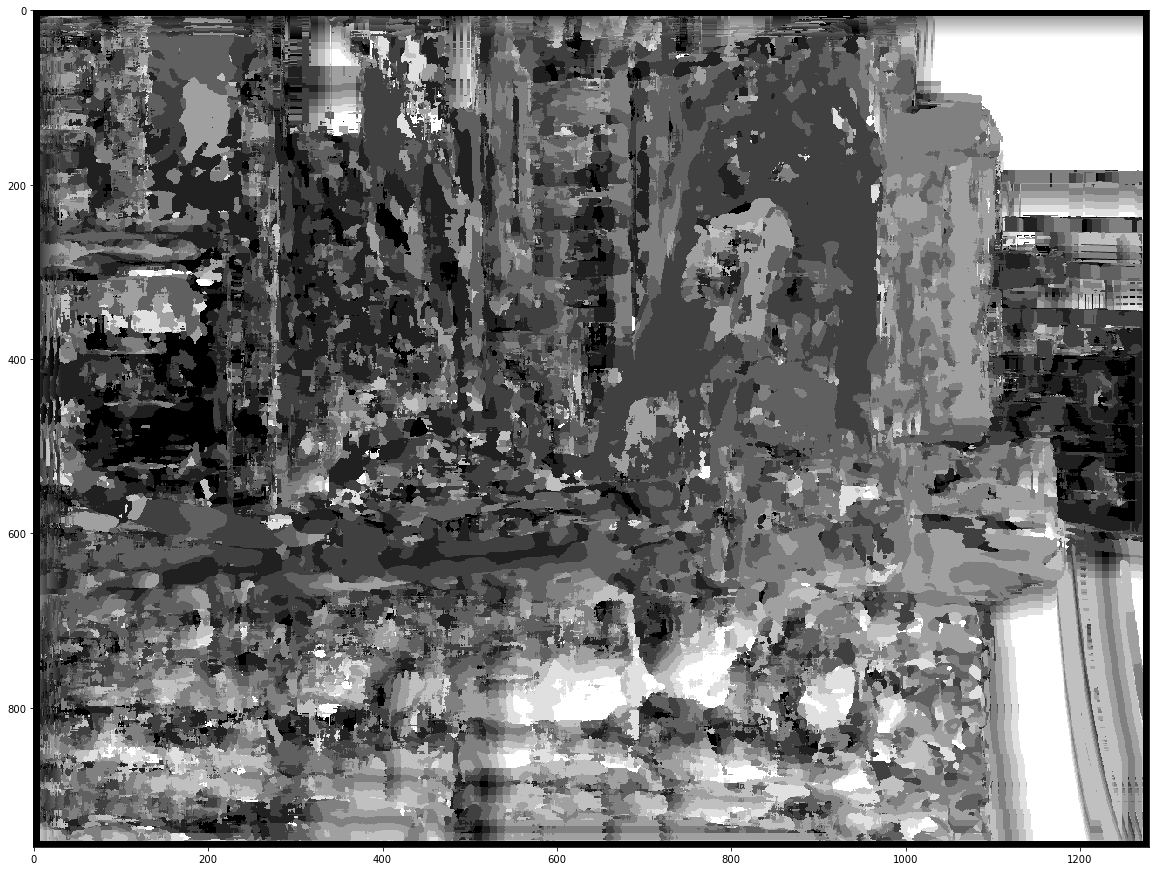

In [34]:
fig1 = plt.figure(figsize=(20, 20))
plt.imshow(match_mask, cmap="gray")
plt.show()